In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! unzip -q drive/MyDrive/NNDL/hw3/PASCAL.zip

In [3]:
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from pascal_dataset import PASCALDataset
from engine import train_one_epoch, evaluate
import utils

In [4]:
num_classes = 5 + 1 # we need one class for background
batch_size = 2

train = PASCALDataset('PASCAL/train')
train_size = len(train)

val = PASCALDataset('PASCAL/val')
test = PASCALDataset('PASCAL/test')

train_data_loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True,
    num_workers=1, collate_fn=utils.collate_fn
)

val_data_loader = torch.utils.data.DataLoader(
    val, batch_size=1, shuffle=True, num_workers=1,
    collate_fn=utils.collate_fn
)

test_data_loader = torch.utils.data.DataLoader(
    test, batch_size=1, shuffle=True, num_workers=1,
    collate_fn=utils.collate_fn
)

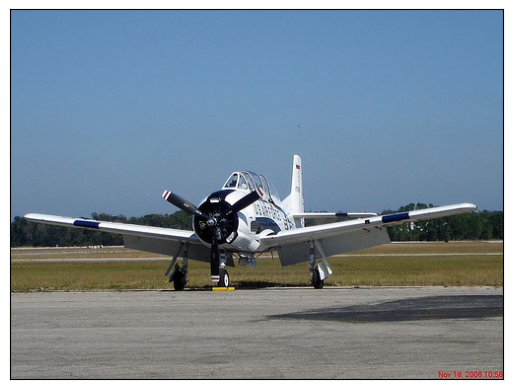

In [5]:
plt.imshow(train[0][0].permute((1, 2, 0)))
plt.xticks([])
plt.yticks([])
plt.show()

In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 343MB/s]


In [ ]:
# model.load_state_dict(
#     torch.load('drive/MyDrive/NNDL/hw3/model.pt')
# )
# model = model.eval()

In [7]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=1, gamma=0.5)

In [8]:
log_interval = int(train_size / batch_size / 5) + 1

for epoch in range(5):
    train_one_epoch (
        model, optimizer, train_data_loader,
        device, epoch, print_freq=log_interval
    )
    lr_scheduler.step()

    evaluate(model, val_data_loader, device=device)

Epoch: [0]  [  0/501]  eta: 1:04:05  lr: 0.000015  loss: 2.2674 (2.2674)  loss_classifier: 1.8887 (1.8887)  loss_box_reg: 0.3514 (0.3514)  loss_objectness: 0.0235 (0.0235)  loss_rpn_box_reg: 0.0038 (0.0038)  time: 7.6754  data: 0.1065  max mem: 2350
Epoch: [0]  [101/501]  eta: 0:04:23  lr: 0.001024  loss: 0.5226 (0.7835)  loss_classifier: 0.2120 (0.4516)  loss_box_reg: 0.3038 (0.3005)  loss_objectness: 0.0025 (0.0124)  loss_rpn_box_reg: 0.0095 (0.0190)  time: 0.5910  data: 0.0099  max mem: 3931
Epoch: [0]  [202/501]  eta: 0:03:11  lr: 0.002033  loss: 0.2256 (0.5691)  loss_classifier: 0.0808 (0.2853)  loss_box_reg: 0.1309 (0.2556)  loss_objectness: 0.0039 (0.0109)  loss_rpn_box_reg: 0.0069 (0.0172)  time: 0.6236  data: 0.0096  max mem: 4118
Epoch: [0]  [303/501]  eta: 0:02:04  lr: 0.003042  loss: 0.2366 (0.4932)  loss_classifier: 0.0765 (0.2272)  loss_box_reg: 0.1373 (0.2378)  loss_objectness: 0.0052 (0.0106)  loss_rpn_box_reg: 0.0141 (0.0176)  time: 0.6155  data: 0.0093  max mem: 4118


In [9]:
torch.save(model.state_dict(), 'drive/MyDrive/NNDL/hw3/model.pt')

In [10]:
class_names = ['human', 'bike', 'car', 'motor cycle', 'airplane']

color_map = [
    (25, 220, 10), (255, 155, 0), (0, 200, 255),
    (110, 0, 255), (255, 30, 0)
]

In [11]:
def detect_objects(img_tensor, confidence=0.5):

    pred = model([img_tensor.to(device)])

    pred_boxes = [
        [(int(box[0]), int(box[1])), (int(box[2]), int(box[3]))]
        for box in list(pred[0]['boxes'].detach().cpu().numpy())
    ]
    pred_labels = list(pred[0]['labels'].cpu().numpy())
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())

    th_indx = -1
    for i in range(len(pred_score)):
        if (pred_score[i] > confidence): th_indx = i+1
        else: break

    if (th_indx == -1): return [], []

    pred_boxes = pred_boxes[:th_indx]
    pred_labels = pred_labels[:th_indx]

    return pred_boxes, pred_labels

In [12]:
def predict_and_plot(img_tensor, confidence=0.5, legend_loc='upper right'):
    pred_boxes, pred_labels = detect_objects(img_tensor, confidence)

    img = img_tensor.permute((1, 2, 0)).numpy() * 255
    img = np.ascontiguousarray(img, dtype=np.uint8)

    for i in range(len(pred_boxes)):
        cv2.rectangle(img, pred_boxes[i][0], pred_boxes[i][1],
            color_map[pred_labels[i]-1], thickness=2)

    handles = [Patch (
            facecolor=(color_map[i-1][0]/255, color_map[i-1][1]/255, color_map[i-1][2]/255),
            label = class_names[i-1] + ': ' + str(pred_labels.count(i))
        ) for i in np.unique(pred_labels)
    ]

    plt.imshow(img)
    plt.legend(handles=handles, loc=legend_loc)
    plt.xticks([])
    plt.yticks([])
    plt.show()

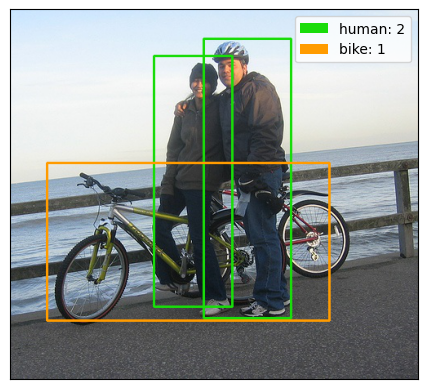

In [13]:
predict_and_plot(test[0][0], 0.8)

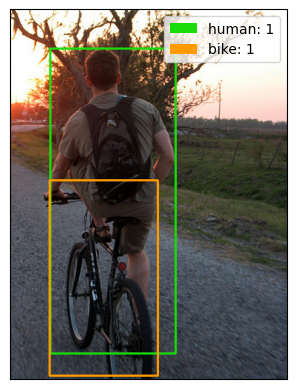

In [14]:
predict_and_plot(test[4][0], 0.8)

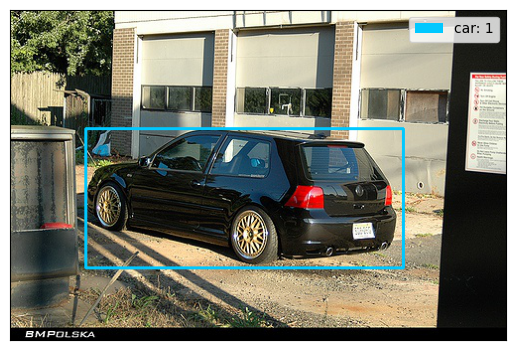

In [15]:
predict_and_plot(test[6][0], 0.8)

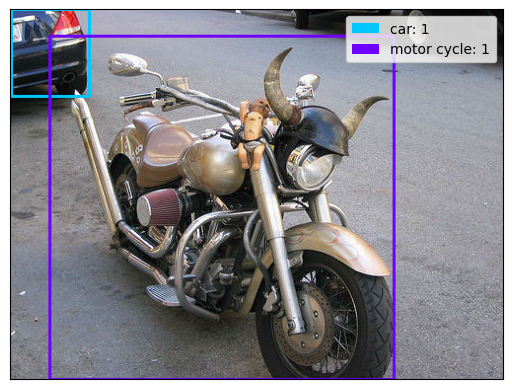

In [16]:
predict_and_plot(test[7][0], 0.8)

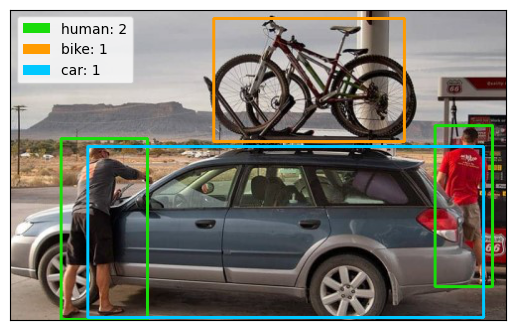

In [17]:
img = Image.open('test_image.jpg')

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

img = transform(img)
predict_and_plot(img, 0.8, 'upper left')

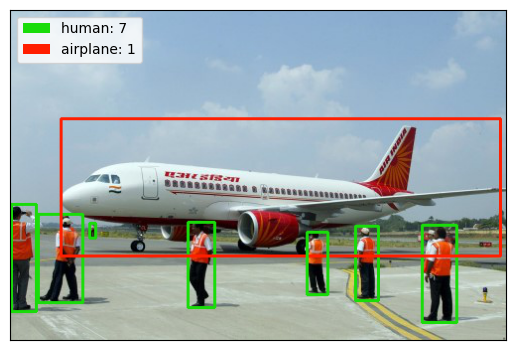

In [18]:
img = Image.open('test_image2.jpg')

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

img = transform(img)
predict_and_plot(img, 0.8, 'upper left')